## General information about the database

**The database can be downloaded here https://www.kaggle.com/nasa/meteorite-landings**
#### Please read the accompaining notes of the database on Kaggle

### Import necessary libraries and modules

In [33]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

### Import data

In [13]:
# Download the file, put it in the same folder of the notebook
# Then load the data into a padas dataframe and see the first lines
df_ml = pd.read_csv('meteorite-landings.csv')
df_ml.head()

,name,id,nametype,recclass,mass,fall,year,reclat,reclong,GeoLocation
0,Aachen,1,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775000, 6.083330)"
1,Aarhus,2,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.183330, 10.233330)"
2,Abee,6,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.216670, -113.000000)"
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976.0,16.88333,-99.90000,"(16.883330, -99.900000)"
4,Achiras,370,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.166670, -64.950000)"


In [14]:
# Use the .info method to get an idea of the dataframe
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45716 entries, 0 to 45715
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         45716 non-null  object 
 1   id           45716 non-null  int64  
 2   nametype     45716 non-null  object 
 3   recclass     45716 non-null  object 
 4   mass         45585 non-null  float64
 5   fall         45716 non-null  object 
 6   year         45428 non-null  float64
 7   reclat       38401 non-null  float64
 8   reclong      38401 non-null  float64
 9   GeoLocation  38401 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 3.5+ MB


##### From the accompaining notes of the database
___Notes on missing or incorrect data points:___
- a few entries here contain date information that was incorrectly parsed into the NASA database. As a spot check: any date that is before 860 CE or after 2016 are incorrect; these should actually be BCE years. There may be other errors and we are looking for a way to identify them.
- a few entries have latitude and longitude of 0N/0E (off the western coast of Africa, where it would be quite difficult to recover meteorites). Many of these were actually discovered in Antarctica, but exact coordinates were not given. 0N/0E locations should probably be treated as NA.

### Database cleaning

In [15]:
# Let's verify the error
df_err_2016 = df_ml.query('year > 2016')
df_err_2016

,name,id,nametype,recclass,mass,fall,year,reclat,reclong,GeoLocation
30679,Northwest Africa 7701,57150,Valid,CK6,55.0,Found,2101.0,0.0,0.00000,"(0.000000, 0.000000)"
38188,Ur,24125,Valid,Iron,NaN,Found,2501.0,30.9,46.01667,"(30.900000, 46.016670)"


In [16]:
## Delete all the rows with the "errors" from the database

# Take the indices (row labels) of the database
index = df_ml.index

# Find the rows with the "errors"
err = (df_ml.year < 860) | (df_ml.year > 2016)

# Extract the indices of the rows with errors and assign them to the variable 'val_err'
val_err = index[err].values

# Delete all the rows with the errors
df_ml.drop(val_err, inplace=True)

In [17]:
# Let's verify that the dataframe is now clean (without weird values)

df_err_2016 = df_ml.query('year > 2016')
df_err_860 = df_ml.query('year < 860')

print(df_err_2016)
print(df_err_860)

Empty DataFrame
Columns: [name, id, nametype, recclass, mass, fall, year, reclat, reclong, GeoLocation]
Index: []
Empty DataFrame
Columns: [name, id, nametype, recclass, mass, fall, year, reclat, reclong, GeoLocation]
Index: []


### Database exploration

In [18]:
# Sort the database for the quantity of material collected
df_mass = df_ml.sort_values(by = 'mass', ascending=False)
df_mass.head(15)

,name,id,nametype,recclass,mass,fall,year,reclat,reclong,GeoLocation
16383,Hoba,11890,Valid,"Iron, IVB",60000000.0,Found,1920.0,-19.58333,17.91667,"(-19.583330, 17.916670)"
5336,Cape York,5262,Valid,"Iron, IIIAB",58200000.0,Found,1818.0,76.13333,-64.93333,"(76.133330, -64.933330)"
5329,Campo del Cielo,5247,Valid,"Iron, IAB-MG",50000000.0,Found,1575.0,-27.46667,-60.58333,"(-27.466670, -60.583330)"
5333,Canyon Diablo,5257,Valid,"Iron, IAB-MG",30000000.0,Found,1891.0,35.05000,-111.03333,"(35.050000, -111.033330)"
3433,Armanty,2335,Valid,"Iron, IIIE",28000000.0,Found,1898.0,47.00000,88.00000,"(47.000000, 88.000000)"
12600,Gibeon,10912,Valid,"Iron, IVA",26000000.0,Found,1836.0,-25.50000,18.00000,"(-25.500000, 18.000000)"
5431,Chupaderos,5363,Valid,"Iron, IIIAB",24300000.0,Found,1852.0,27.00000,-105.10000,"(27.000000, -105.100000)"
26293,Mundrabilla,16852,Valid,"Iron, IAB-ung",24000000.0,Found,1911.0,-30.78333,127.55000,"(-30.783330, 127.550000)"
916,Sikhote-Alin,23593,Valid,"Iron, IIAB",23000000.0,Fell,1947.0,46.16000,134.65333,"(46.160000, 134.653330)"
4981,Bacubirito,4919,Valid,"Iron, ungrouped",22000000.0,Found,1863.0,26.20000,-107.83333,"(26.200000, -107.833330)"


#### Very interesting: the collected metereorites with the greatest mass are the iron meteorites (column "recclass": Iron)

In [19]:
# Let's create a nw column 'met_type' to differenciate between stony and iron meteorites
df_ml['met_type'] = np.where(df_ml['recclass'].str.contains('Iron')==True, 'Metallic', 'Stony')


# Now let's calculate the sum of the collected material for stony are iron meteorites
df_ml.groupby('met_type')['mass'].sum()

met_type
Metallic    5.145273e+08
Stony       9.075349e+07
Name: mass, dtype: float64

In [20]:
# The sum of the masses of all metallic meteorites is larger than the stony ones
# even though the number of stony meteorites is by far larger than the metallic meteorites
# This is shown in the following lines of code:

# Total count of stony meteorites
st = (df_ml.met_type == 'Stony')
tot_st = df_ml[st].met_type.value_counts()
print('Total number of stony meteorites is:', tot_st)

# Total count of metallic meteorites
mt = (df_ml.met_type == 'Metallic')
tot_mt = df_ml[mt].met_type.value_counts()
print('Total number of metallic meteorites is:', tot_mt)

Total number of stony meteorites is: Stony    44646
Name: met_type, dtype: int64
Total number of metallic meteorites is: Metallic    1066
Name: met_type, dtype: int64


### From a quick database analyis we retrieved the following insights:
- Stony meteorites are about 40 times more aboundant than metallic ones
- Total mass of metallic meteorites is about 6 times larger than stony meteorites
- Metallic meteorites tends to have larger mass with respect to stony meteorites

#### Now I want to understand if meteorite findings take place preferencially in some regions of the Earth. In particular I want to know if the distribution of the meteorites as a function of latitudeis casual or not

In [21]:
# Divido la Terra in cinque regioni in funzione della latitudine
# Let's divide the Earth in 5 regions as a function of latitude
# CPAr = artic ice cap from +90° to +66° (numbers in the column "reclat")
# FTB = temperate borealis zone from + 66° to +23°
# EQT = equator from +23° to -23°
# FTA = temperate australis zone from -23° to -66°
# CPAn = antarctic ice sheet from -66° to -90°

bins = [90, 66, 23, -23, -66]
names = ['CPAr', 'FTB', 'EQT', 'FTA', 'CPAn']

d = dict(enumerate(names, 1))
df_ml['Lat_zones'] = np.vectorize(d.get)(np.digitize(df_ml['reclat'], bins))

In [22]:
# Let's group-by the meterotite for each zone and calculate the sum
df_ml.groupby('Lat_zones')['mass'].sum().sort_values()

Lat_zones
CPAn    3.886682e+06
None    8.810212e+06
CPAr    6.067414e+07
EQT     1.197631e+08
FTA     1.440999e+08
FTB     2.680467e+08
Name: mass, dtype: float64

In [23]:
df_ml

,name,id,nametype,recclass,mass,fall,year,reclat,reclong,GeoLocation,met_type,Lat_zones
0,Aachen,1,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775000, 6.083330)",Stony,FTB
1,Aarhus,2,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.183330, 10.233330)",Stony,FTB
2,Abee,6,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.216670, -113.000000)",Stony,FTB
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976.0,16.88333,-99.90000,"(16.883330, -99.900000)",Stony,EQT
4,Achiras,370,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.166670, -64.950000)",Stony,FTA
...,...,...,...,...,...,...,...,...,...,...,...,...
45711,Zillah 002,31356,Valid,Eucrite,172.0,Found,1990.0,29.03700,17.01850,"(29.037000, 17.018500)",Stony,FTB
45712,Zinder,30409,Valid,"Pallasite, ungrouped",46.0,Found,1999.0,13.78333,8.96667,"(13.783330, 8.966670)",Stony,EQT
45713,Zlin,30410,Valid,H4,3.3,Found,1939.0,49.25000,17.66667,"(49.250000, 17.666670)",Stony,FTB
45714,Zubkovsky,31357,Valid,L6,2167.0,Found,2003.0,49.78917,41.50460,"(49.789170, 41.504600)",Stony,FTB


#### The group-by function gives us an addition group "none" with all the meteorites for which lat and long data were not avalible. As explained in the accompaining notes most of these meteorites were collected in Antartica so basically the "none" group has to be added to the CPAn group. Indeed many scientific expeditions are organized every year to collect meteorites in Antartica so we may conclude that Antartica is the best place to collect meteorites

### Let's have some more fun --> plotting on map meteorite fall!!!

#### (make sure to have installed geopandas and geoplot libraries on your machine)

In [6]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

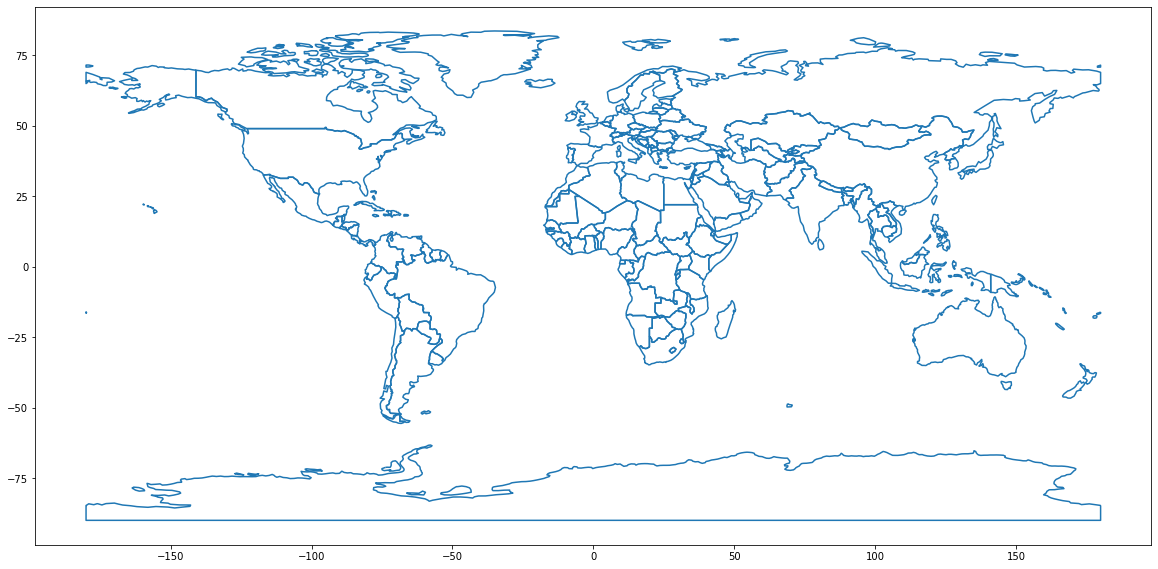

In [35]:
#world.boundary.plot()
ax = world.boundary.plot(figsize=(20, 20))

In [26]:
# We need to define the Coordinate Reference System (crs)
crs = {'init': 'epsg:4326'}

# Then we have to create the point objects using the coordinates
geometry = [Point(xy) for xy in zip(df_ml['reclong'], df_ml['reclat'])]

In [29]:
# Now we need to create a special dataframe called GEODATAFRAME --> geo_df

geo_df = gpd.GeoDataFrame(df_ml, # this is the source of our data
                          crs = crs, # This is the coordinate reference system
                          geometry = geometry)  # This are the point that we created

In [30]:
df_ml

,name,id,nametype,recclass,mass,fall,year,reclat,reclong,GeoLocation,met_type,Lat_zones,geometry
0,Aachen,1,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775000, 6.083330)",Stony,FTB,POINT (6.08333 50.77500)
1,Aarhus,2,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.183330, 10.233330)",Stony,FTB,POINT (10.23333 56.18333)
2,Abee,6,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.216670, -113.000000)",Stony,FTB,POINT (-113.00000 54.21667)
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976.0,16.88333,-99.90000,"(16.883330, -99.900000)",Stony,EQT,POINT (-99.90000 16.88333)
4,Achiras,370,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.166670, -64.950000)",Stony,FTA,POINT (-64.95000 -33.16667)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45711,Zillah 002,31356,Valid,Eucrite,172.0,Found,1990.0,29.03700,17.01850,"(29.037000, 17.018500)",Stony,FTB,POINT (17.01850 29.03700)
45712,Zinder,30409,Valid,"Pallasite, ungrouped",46.0,Found,1999.0,13.78333,8.96667,"(13.783330, 8.966670)",Stony,EQT,POINT (8.96667 13.78333)
45713,Zlin,30410,Valid,H4,3.3,Found,1939.0,49.25000,17.66667,"(49.250000, 17.666670)",Stony,FTB,POINT (17.66667 49.25000)
45714,Zubkovsky,31357,Valid,L6,2167.0,Found,2003.0,49.78917,41.50460,"(49.789170, 41.504600)",Stony,FTB,POINT (41.50460 49.78917)


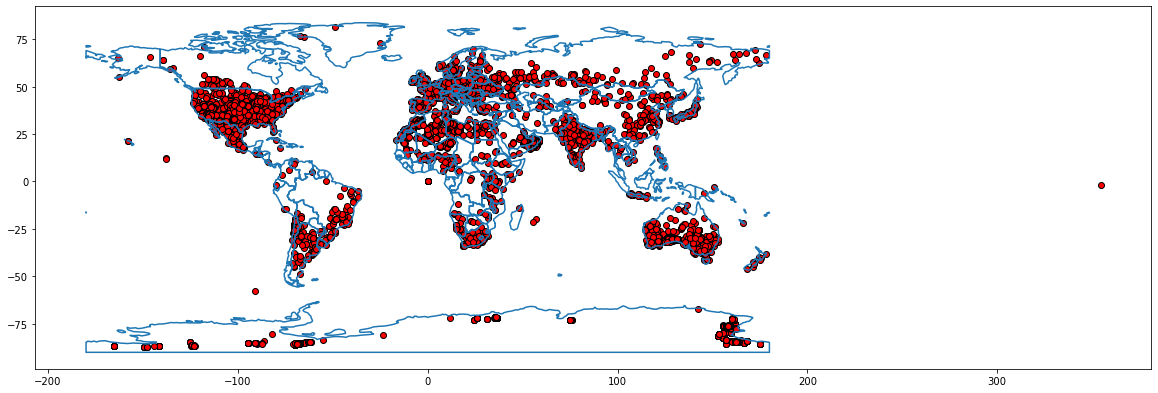

In [37]:
# At this point we are ready to plot our geo_df on top of the map
ax = world.boundary.plot(figsize=(20, 20))
geo_df.plot(ax = ax, color='red', edgecolor='black', figsize=(20, 20))

plt.show()

### Cool!!! Isn't it? but still we need more freedom to select a place, zoom in, zoom out etc.

In [38]:
#Let's use this command to open up the picture in another window
%matplotlib qt5

# same as before we plot the world basic map and the meteorite falls on top of it
ax = world.boundary.plot(figsize=(20, 20))
geo_df.plot(ax = ax, color='red', edgecolor='black', figsize=(20, 20))

plt.show()